In [37]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import sqlite3
import torch

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualFlow.yaml']

config = Config()

In [3]:
model = get_model(config.architecture, config)
# print(model.model)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.37s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [15]:
print(model.model)

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [16]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


In [4]:
db_path = model.config.output_db
print(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

../output/Qwen2-VL-2B-Instruct-VisualFlow.db


In [5]:
for r in cursor.execute("""
  SELECT id, image_id, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 20
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data/test-images/black_in_blue.png', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 129])', 'tensor_bytes': 2204}
{'id': 2, 'image_id': None, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data/test-images/black_in_blue.png', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'visual.blocks.31', 'pooling_method': None, 'tensor_dim': 1280, 'tensor_shape': 'torch.Size([392, 1280])', 'tensor_bytes': 1004700}
{'id': 3, 'image_id': None, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data/test-images/black_in_blue.png', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'visual.merger', 'pooling_method': None, 'tensor_dim': 1536, 'tensor

In [6]:
for r in cursor.execute("""
  SELECT id, name, label, image_path, layer, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  WHERE layer = "visual.merger"
  LIMIT 20
"""):
    print(dict(r))

{'id': 3, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'label': None, 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data/test-images/black_in_blue.png', 'layer': 'visual.merger', 'tensor_dim': 1536, 'tensor_shape': 'torch.Size([98, 1536])', 'tensor_bytes': 302236}
{'id': 9, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'label': None, 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data/test-images/black_in_black.png', 'layer': 'visual.merger', 'tensor_dim': 1536, 'tensor_shape': 'torch.Size([98, 1536])', 'tensor_bytes': 302236}


In [ ]:
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda"
)

post_llm_embeddings = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="model.norm",
    device="cuda"
)


input_ids = np.squeeze(np.array(tuple(map(list, zip(*input_ids)))[1])) # B x T
print(input_ids)
# print(torch.tensor(np.array(input_ids)).shape)

post_llm_embeddings = np.squeeze(np.array(tuple(map(list, zip(*post_llm_embeddings)))[1])) # B x T x D
# print(torch.tensor(np.array(post_llm_embeddings)).shape)



visual_embs, n_visual_embs = db_utils.extract_visual_embeddings(
    input_ids=input_ids,
    llm_embeddings=post_llm_embeddings,
    image_token_id=IMAGE_TOKEN_IDS['qwen'])

mean_embs = db_utils.compute_mean_embeddings(
    embeddings=visual_embs,
    n_embeddings=n_visual_embs)

db_utils.cosine_similarity_numpy(mean_embs, mean_embs)


[[151644   8948    198   2610    525    264  10950  17847     13 151645
     198 151644    872    198 151652 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151655 151655 151655 151655 151655 151655 151655
  151655 151655 151655 151653  74785    279   1894    304    419   2168
     304    825   3409     13 151645    198 151644  77091    198]
 [151644   8948    198   2610    525    264  10950  17847     13 15164

np.float64(0.9883939244138062)

In [39]:
print(config.modules)

module_names = []
module_embeddings = []
# Get input_ids
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda")
input_ids = db_utils.unwrap_embeddings(input_ids)

for module in config.modules:
    module_name = module.pattern
    module_embedding = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=module.pattern
    )
    module_embedding = db_utils.unwrap_embeddings(module_embedding)

    # Compute mean embedding of visual tokens only (if applicable)
    if module_name.startswith("model."):
        module_visual_embedding, n_visual_tokens = db_utils.extract_visual_embeddings(
            input_ids=input_ids,
            llm_embeddings=module_embedding,
            image_token_id=IMAGE_TOKEN_IDS[config.architecture]
        )
        # Calculate mean embedding
        visual_mean_embeddings = db_utils.compute_mean_embeddings(
            embeddings=module_visual_embedding,
            n_embeddings=n_visual_tokens)
        module_names.append("{}-visual".format(module_name))
        module_embeddings.append(visual_mean_embeddings)

    # Calculate mean embedding
    mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=module_embedding)

    module_names.append(module_name)
    module_embeddings.append(mean_embeddings)

# TODO: for each unique layer in DB (or is this saved in model.config?), get the embedding representations
# TODO: Create similarity matrix for each pair of layers (averaged over (B * (B-1) / 2)), and save a visual representation

n_modules = len(module_names)

comparison_names = []
cosine_sims = []
for i in range(n_modules - 1):
    for j in range(i + 1, n_modules):
        # Check embeddings are same dimensions
        embedding_i = module_embeddings[i]
        embedding_j = module_embeddings[j]
        if not embedding_i.shape == embedding_j.shape:
            continue

        name_i = module_names[i]
        name_j = module_names[j]

        # Calculate cosine sim
        cosine_sim = db_utils.cosine_similarity_numpy(embedding_i, embedding_j)
        # Only want diagonal because that is comparing same image to same image
        cosine_sim = np.diag(cosine_sim)

        comparison_names.append("{}-{}".format(name_i, name_j))
        cosine_sims.append(cosine_sim)

[regex.Regex('visual.blocks.31', flags=regex.V0), regex.Regex('visual.merger', flags=regex.V0), regex.Regex('model.layers.27.post_attention_layernorm', flags=regex.V0), regex.Regex('model.norm', flags=regex.V0), regex.Regex('lm_head', flags=regex.V0)]
matrices
matrices
matrices
matrices
matrices
matrices
matrices
matrices
matrices
matrices


/n/fs/ac-aiexhibit/vlm-lens/notebooks/../src/visualizations.py:815: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


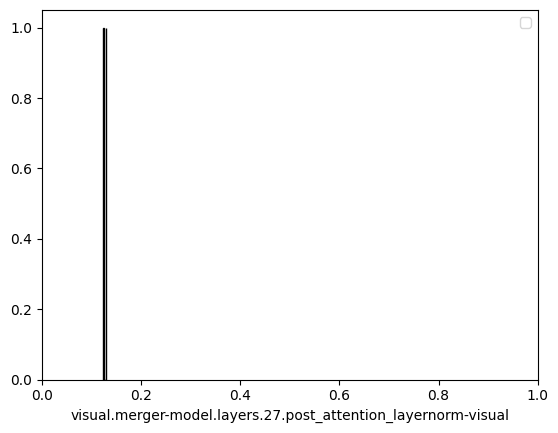

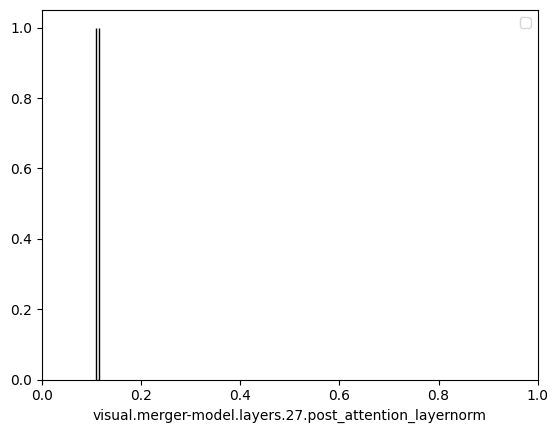

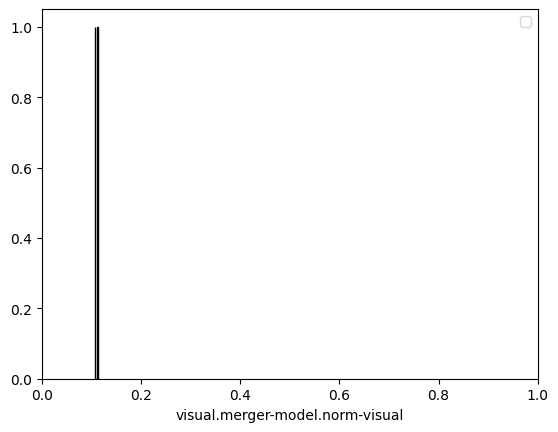

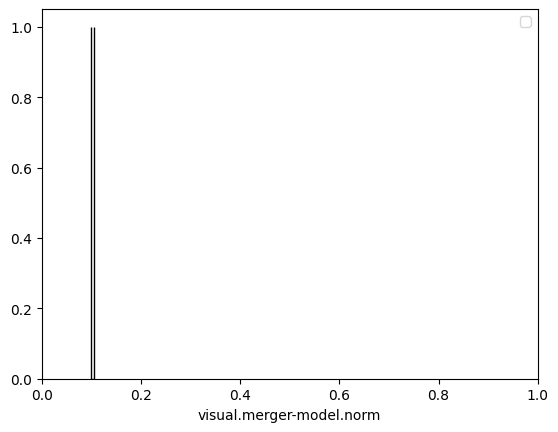

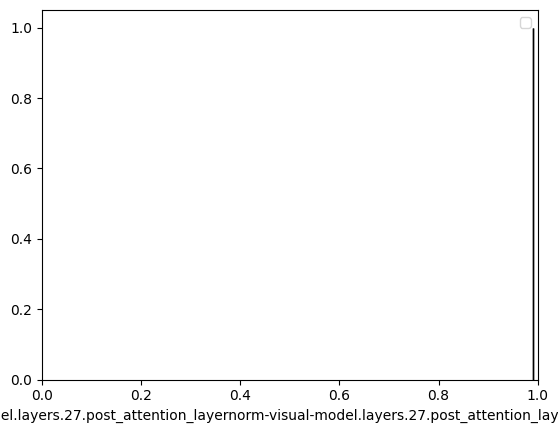

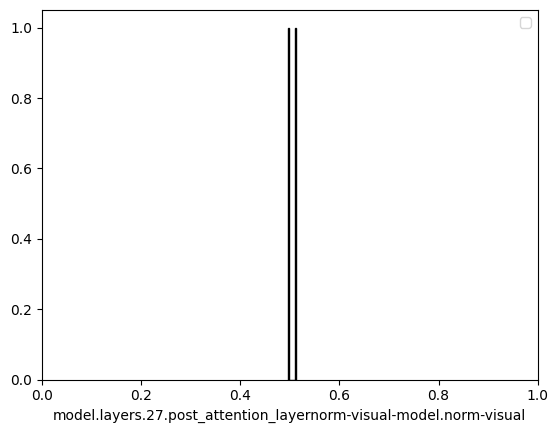

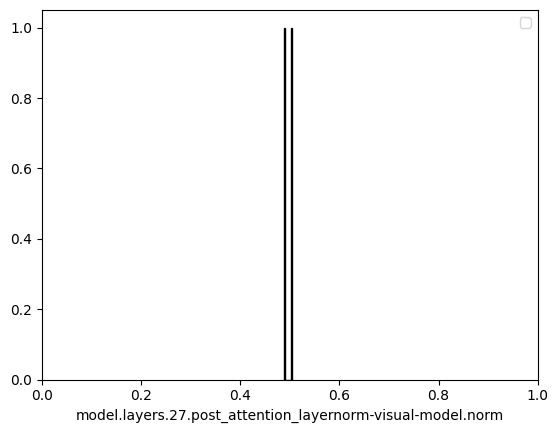

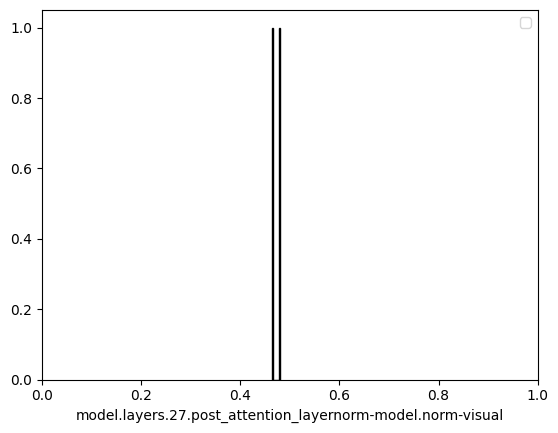

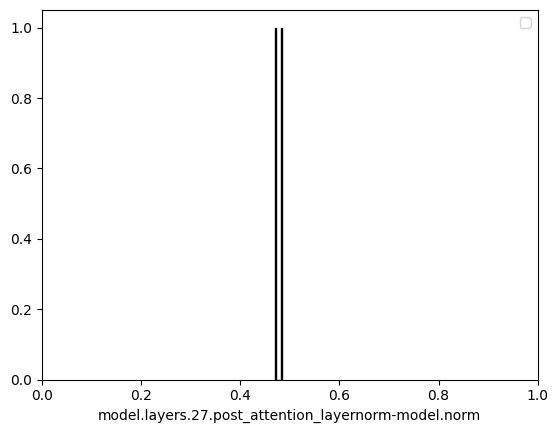

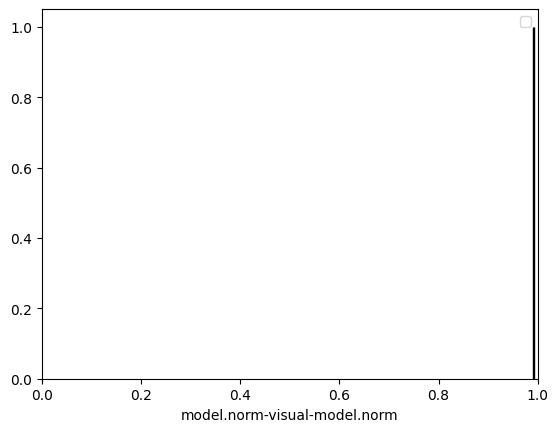

<Figure size 640x480 with 0 Axes>

In [46]:
n_graphs = len(comparison_names)
# fig, axes = plt.subplots(1, 3)

for idx in range(n_graphs):
    # ax = axes[idx]
    comparison_name = comparison_names[idx]
    cosine_sim = cosine_sims[idx]

    visualizations.histogram(
        data=cosine_sim,
        xlim=[0, 1],
        xlabel=comparison_name,
        show=True
    )